# Compito di Analisi Numerica - Marzo 2025 - Michele Colombi
Nel presente notebook andiamo ad implementare diversi metodi numerici e studiarne il comportamento per i tre problemi seguenti:

1. Problema dei due corpi
2. Problema stiff
3. Oscilattore armonico


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions import * 

## 1. Problema dei due corpi

Testiamo la dispersione di energia totale del problema dei due corpi, per vari metodi impliciti ed espliciti:

- Backward Differences
- Implicit Runge-Kutta (IRK)
- Crank Nicholson (PM)
- Heun
- Adams-Bashforth (AB)

L'equazione, in forma di sistema del primo ordine, è data da:

$$
\begin{cases}
\frac{d\mathbf{r}}{dt} = \mathbf{v}, \\
\frac{d\mathbf{v}}{dt} = -\frac{G m_2}{m_1 + m_2} \cdot \frac{\mathbf{r}}{|\mathbf{r}|^3},
\end{cases}
$$

con:

$$
\mathbf{r}(0) = (1, -1), \quad \mathbf{v}(0) = (0,1), \quad G = 1, \quad m_1 = 1, \quad m_2 = 10.
$$

In [2]:
# Costanti fisiche
G = 1
m1 = 1
m2 = 10

# Campo f
def f(t, x):
    denom = (x[0]**2 + x[1]**2)**(3/2)
    mu = G * m2 / (m1 + m2)
    return np.array([
        x[2],
        x[3],
        -mu * x[0] / denom,
        -mu * x[1] / denom
    ])

# Jacobiana del campo
def Jf(t, x):
    r2 = x[0]**2 + x[1]**2
    r5 = r2**(5/2)
    r3 = r2**(3/2)
    mu = G * m2 / (m1 + m2)

    J = np.array([
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [mu * (3 * x[0]**2 / r5 - 1 / r3), mu * (3 * x[0]*x[1] / r5), 0, 0],
        [mu * (3 * x[0]*x[1] / r5), mu * (3 * x[1]**2 / r5 - 1 / r3), 0, 0]
    ])
    return J

# Condizione iniziale e intervallo di integrazione
y0 = np.array([1, -1, 0, 1])
tspan = [0, 100]

Riportiamo qui i Tablau di Butcher che caratterizzano diversi metodi IRK (impliciti) e ERK (espliciti) che verranno utilizzati nel resto del notebook.

In [22]:
# Selezionare un tableau diverso cambiando ERK/IRK_form
IRK_form = 1

if IRK_form == 0:
    A = np.array([[1/2]])
    b = np.array([1])
    c = np.array([1/2])
    q = 1
    p = 2

elif IRK_form == 1:
    A = np.array([
        [1/4, 1/4 - np.sqrt(3)/6],
        [1/4 + np.sqrt(3)/6, 1/4]
    ])
    b = np.array([1/2, 1/2])
    c = np.array([1/2 - np.sqrt(3)/6, 1/2 + np.sqrt(3)/6])
    q = 2
    p = 4

elif IRK_form == 2:
    A = np.array([
        [5/36, 2/9 - np.sqrt(15)/15, 5/36 - np.sqrt(15)/30],
        [5/36 + np.sqrt(15)/24, 2/9, 5/36 - np.sqrt(15)/24],
        [5/36 + np.sqrt(15)/30, 2/9 + np.sqrt(15)/15, 5/36]
    ])
    b = np.array([5/18, 4/9, 5/18])
    c = np.array([1/2 - np.sqrt(15)/10, 1/2, 1/2 + np.sqrt(15)/10])
    q = 3
    p = 6

elif IRK_form == 3:  # Radau I
    A = np.array([
        [1/3, 0],
        [1, 0]
    ])
    b = np.array([3/4, 1/4])
    c = np.array([1/3, 1])
    q = 2
    p = 3

elif IRK_form == 4:  # Radau II
    A = np.array([
        [(24 - np.sqrt(6))/120, (24 - 11*np.sqrt(6))/120, 0],
        [(24 + 11*np.sqrt(6))/120, (24 + np.sqrt(6))/120, 0],
        [(6 - np.sqrt(6))/12, (6 + np.sqrt(6))/12, 0]
    ])
    b = np.array([(16 - np.sqrt(6))/36, (16 + np.sqrt(6))/36, 1/9])
    c = np.array([(4 - np.sqrt(6))/10, (4 + np.sqrt(6))/10, 1])
    q = 3
    p = 5
    

ERK_form = 0 

if ERK_form == 0:
    AE = np.array([
        [0,   0,   0, 0],
        [1/2, 0,   0, 0],
        [0,   1/2, 0, 0],
        [0,   0,   1, 0]
    ])
    bE = np.array([1/6, 1/3, 1/3, 1/6])
    cE = np.array([0, 1/2, 1/2, 1])
    qE = 4
    pE = 4

elif ERK_form == 1:
    AE = np.array([
        [0,    0,   0, 0],
        [1/3,  0,   0, 0],
        [-1/3, 1,   0, 0],
        [1,   -1,   1, 0]
    ])
    bE = np.array([1/8, 3/8, 3/8, 1/8])
    cE = np.array([0, 1/3, 2/3, 1])
    qE = 4
    pE = 4

Qui calcoliamo numericamente l'ordine di consistenza, la soluzione numerica e il costo computazionale (in termini di valutazione del campo) per i metodi di cui sopra.

In [4]:
num_h_test = 10
h_test = np.logspace(-3, -1.5, num_h_test)
num_eval = np.zeros((5, num_h_test))  

for i in range(num_h_test):
    Ti = np.arange(tspan[0], tspan[1] + h_test[i], h_test[i])

    # BDF
    y_BDF, eval_BDF = bdf(f, Jf, Ti, y0)
    num_eval[0, i] = eval_BDF

    # IRK
    _, y_IRK, eval_IRK = irk_solver(f, y0, Ti, A, b, c, Jf)
    num_eval[1, i] = eval_IRK

    # Midpoint (ERK2)
    y_ERK2, eval_ERK2 = midpoint(f, y0, Ti)
    num_eval[2, i] = eval_ERK2

    # Adams-Bashforth (ordine 3)
    y_AB3, eval_AB3 = ab(f, Ti, y0, k=2)
    num_eval[3, i] = eval_AB3

    # Heun (ERK3)
    y_ERK3, eval_ERK3 = heun(f, y0, Ti)
    num_eval[4, i] = eval_ERK3


Qui sono rappresentate le orbite numeriche per i diversi metodi.

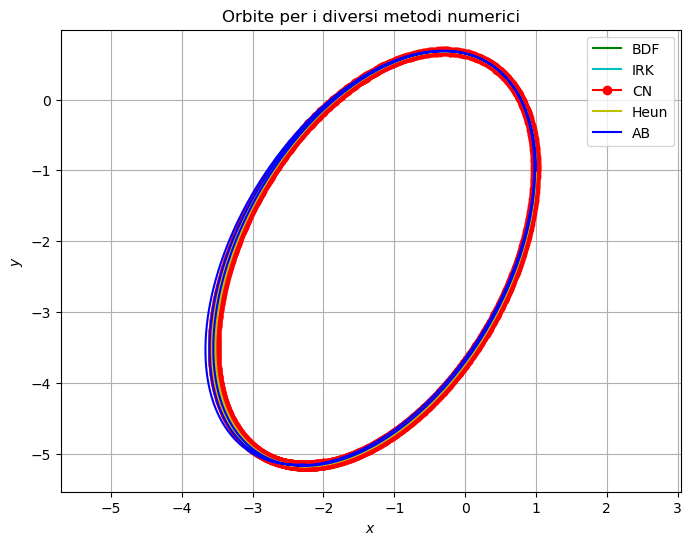

In [5]:
plt.figure(figsize=(8, 6))

plt.plot(y_BDF[0, :], y_BDF[1, :], 'g', label='BDF')
plt.plot(y_IRK[0, :], y_IRK[1, :], 'c', label='IRK')
plt.plot(y_ERK2[0, :], y_ERK2[1, :], 'o-r', label='CN') 
plt.plot(y_ERK3[0, :], y_ERK3[1, :], 'y', label='Heun')
plt.plot(y_AB3[0, :], y_AB3[1, :], 'b', label='AB')

plt.title("Orbite per i diversi metodi numerici")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

Mostriamo ora come e in che misura è conservata l'energia totale nel tempo, per vari metodi. Siccome i metodi non sono simplettici, la quantità non è conservata in modo esatto nel tempo. 

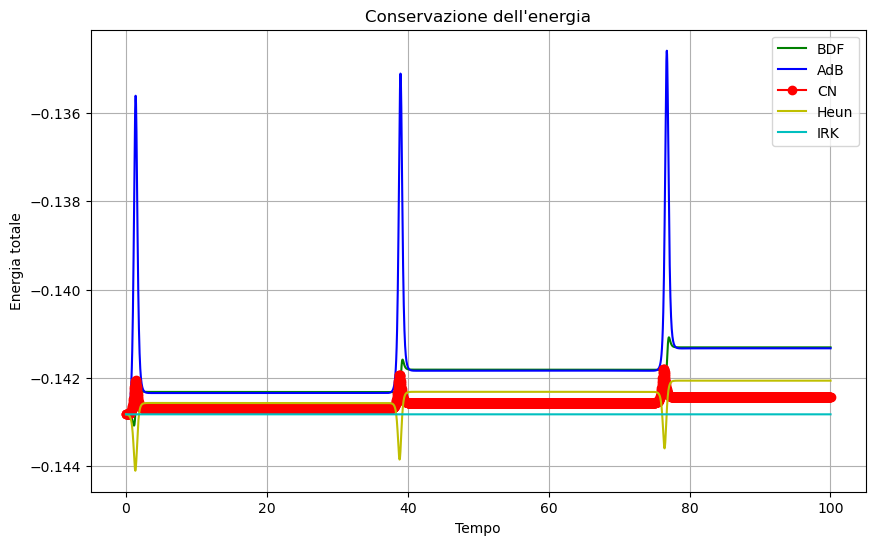

In [6]:
def energia_totale(y):
    # y: matrice 4 x N, con [x, y, vx, vy]
    vx = y[2, :]
    vy = y[3, :]
    r = np.sqrt(y[0, :]**2 + y[1, :]**2)
    energia = 0.5 * (vx**2 + vy**2) - G * m2 / (m1 + m2) / r
    return energia

E_BDF = energia_totale(y_BDF)
E_IRK = energia_totale(y_IRK)
E_ERK2 = energia_totale(y_ERK2)
E_ERK3 = energia_totale(y_ERK3)
E_AB3 = energia_totale(y_AB3)

plt.figure(figsize=(10, 6))
plt.plot(Ti, E_BDF, 'g', label='BDF')
plt.plot(Ti, E_AB3, 'b', label='AdB')
plt.plot(Ti, E_ERK2, 'o-r', label='CN')   
plt.plot(Ti, E_ERK3, 'y', label='Heun')
plt.plot(Ti, E_IRK, 'c', label='IRK')

plt.xlabel("Tempo")
plt.ylabel("Energia totale")
plt.title("Conservazione dell'energia")
plt.legend()
plt.grid(True)
plt.show()

Qui stampiamo il costo computazionale dei due metodi. Notiamo che i metodi espliciti richiedono meno valutazioni del campo.

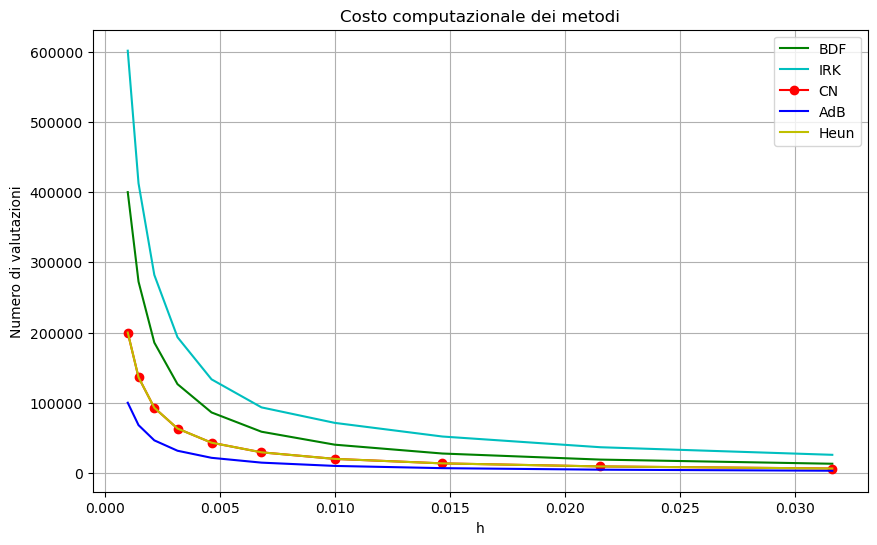

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(h_test, num_eval[0, :], 'g', label='BDF')
plt.plot(h_test, num_eval[1, :], 'c', label='IRK')
plt.plot(h_test, num_eval[2, :], 'o-r', label='CN')    
plt.plot(h_test, num_eval[3, :], 'b', label='AdB')     
plt.plot(h_test, num_eval[4, :], 'y', label='Heun')

plt.xlabel("h")
plt.ylabel("Numero di valutazioni")
plt.title("Costo computazionale dei metodi")
plt.legend()
plt.grid(True)
#plt.xscale("log")  
plt.show()

## 2. Problema stiff
Testiamo convergenza e costo computazionale di diversi RK impliciti ed espliciti per un problema stiff, di equazione

$$
\dot{y} = -100(y - \sin(t)), \quad y(0) = 1, \quad t \in [0, 3].
$$

In [8]:
from sympy import symbols, Function, dsolve, Eq, sin
from sympy.utilities.lambdify import lambdify

# Funzione stiff
def f(t, y):
    return -100 * (y - np.sin(t))

# Jacobiana della funzione
def J(t, y):
    return -100

# Condizione iniziale e intervallo di integrazione
y0 = np.array([1.0])
tspan = [0, 3]

# Soluzione esatta (formulazione simbolica tramite sympy)
t_sym = symbols('t')
y_sym = Function('y')(t_sym)
ode = Eq(y_sym.diff(t_sym), -100 * (y_sym - sin(t_sym)))
cond = {y_sym.subs(t_sym, 0): 1}
y_sol = dsolve(ode, ics=cond).rhs

# Soluzione esatta (formulazione numerica)
sol = lambdify(t_sym, y_sol, modules="numpy")

Qui calcoliamo numericamente l'ordine di consistenza, la soluzione numerica e il costo computazionale (in termini di valutazione del campo) per un metodo RK esplicito ed un RK implicito.

In [9]:
num_h_test=15
h_test = np.logspace(-3, -2, num_h_test)
relative_error_I = np.zeros(num_h_test)
relative_error_E = np.zeros(num_h_test)
num_fval = np.zeros(num_h_test)
num_fvalE = np.zeros(num_h_test)

for i in range(num_h_test):
    Ti = np.arange(tspan[0], tspan[1] + h_test[i], h_test[i])
    sol_eval = sol(Ti)  

    # IRK (implicito)
    y, n_fval = irk_scal_solver(f, y0, Ti, A, b, c, J)
    num_fval[i] = n_fval

    # ERK (esplicito)
    yE, n_fvalE = erk_solver(f, y0, Ti, AE, bE, cE)
    num_fvalE[i] = n_fvalE

    # Errore relativo (norma L2 relativa)
    relative_error_I[i] = np.linalg.norm(y - sol_eval) / np.linalg.norm(y)
    relative_error_E[i] = np.linalg.norm(yE - sol_eval) / np.linalg.norm(yE)

Mostriamo ora graficamente la soluzione numerica confrontandola con quella esatta. Mettendo un passo  maggiore, otteniamo soluzioni numeriche "distanti", ad esempio `h_test=logspace(-2,-1.8,num_h_test)` e `h_test=logspace(-2,-1,num_h_test)`. 


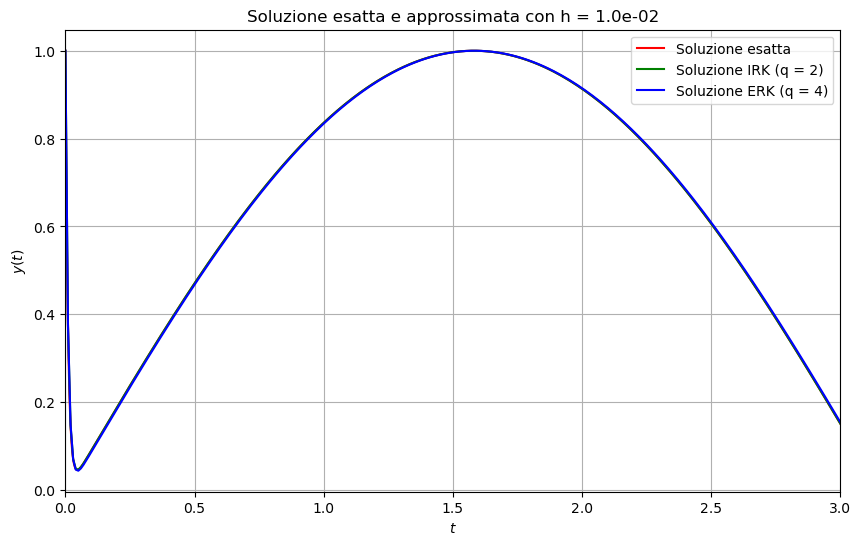

In [10]:
plt.figure(figsize=(10, 6))
plt.grid(True)

plt.xlim(tspan[0], tspan[1])
t_dense = np.linspace(tspan[0], tspan[1], 1000)
plt.plot(t_dense, sol(t_dense), 'r', label="Soluzione esatta")
plt.plot(Ti, np.squeeze(y), 'g', label=f"Soluzione IRK (q = {q})")
plt.plot(Ti, np.squeeze(yE), 'b', label=f"Soluzione ERK (q = {qE})")
plt.xlabel(r"$t$")
plt.ylabel(r"$y(t)$")
plt.title(f"Soluzione esatta e approssimata con h = {h_test[-1]:.1e}")
plt.legend()
plt.show()

Qui stampiamo l'ordine di convergenza numerico, in confronto a quello teorico. Notiamo che il metodo esplicito ha in realtà ordine peggiore rispetto al risultato teorico $q=4$.

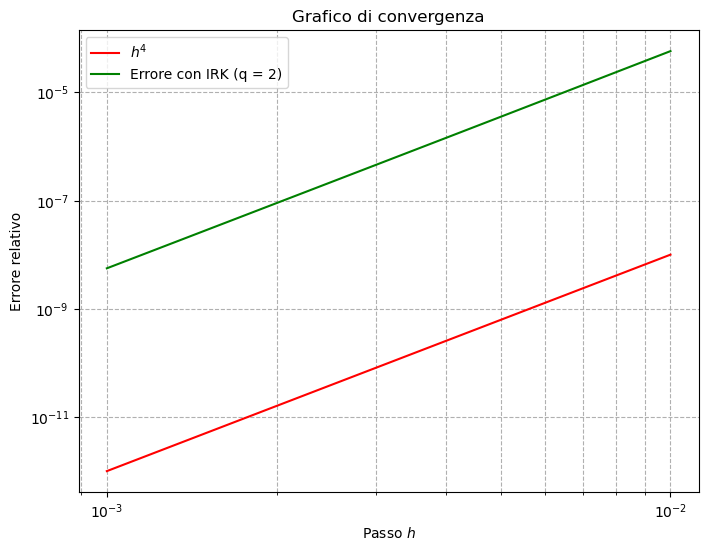

In [11]:
plt.figure(figsize=(8, 6))
plt.grid(True, which="both", ls="--")

plt.loglog(h_test, h_test**p, 'r', label=f"$h^{p}$")
plt.loglog(h_test, relative_error_I, 'g', label=f"Errore con IRK (q = {q})")

plt.xlabel("Passo $h$")
plt.ylabel("Errore relativo")
plt.title("Grafico di convergenza")
plt.legend()
plt.show()

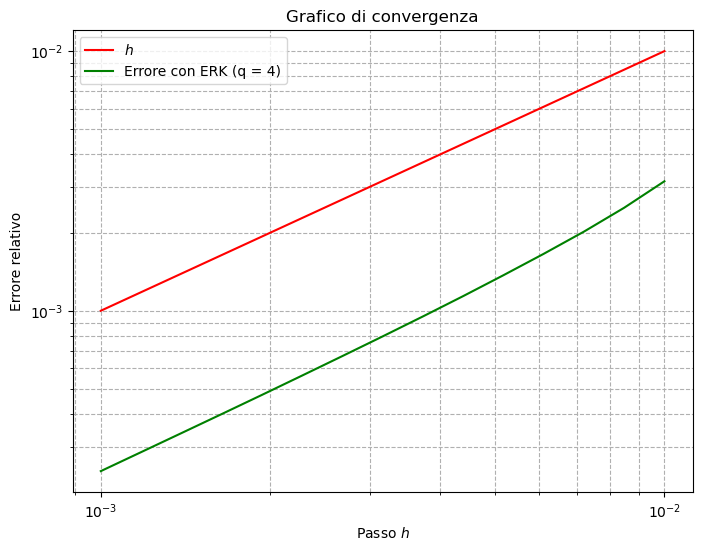

In [12]:
plt.figure(figsize=(8, 6))
plt.grid(True, which="both", ls="--")

plt.loglog(h_test, h_test, 'r', label="$h$")
plt.loglog(h_test, relative_error_E, 'g', label=f"Errore con ERK (q = {qE})")

plt.xlabel("Passo $h$")
plt.ylabel("Errore relativo")
plt.title("Grafico di convergenza")
plt.legend()
plt.show()

Qui stampiamo il costo computazionale dei due metodi. Notiamo che il metodo esplicito richiede (approssimativamente) la metà delle valutazioni del campo.


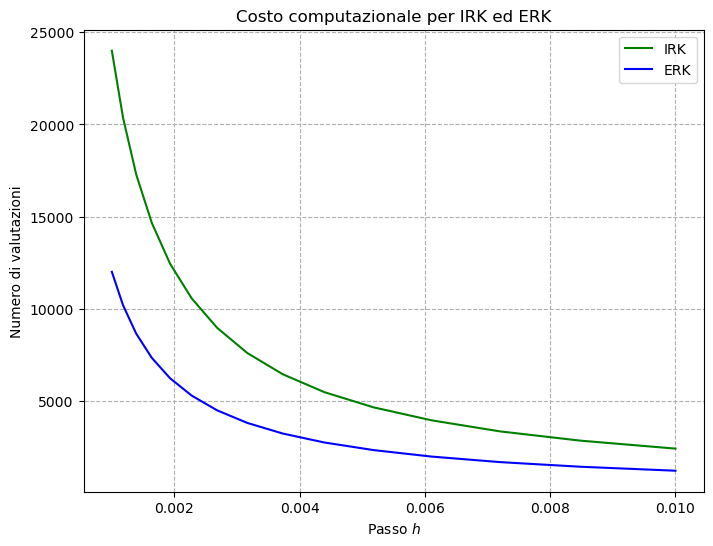

In [13]:
plt.figure(figsize=(8, 6))
plt.grid(True, which="both", ls="--")

plt.plot(h_test, num_fval, 'g', label='IRK')
plt.plot(h_test, num_fvalE, 'b', label='ERK')

plt.xlabel("Passo $h$")
plt.ylabel("Numero di valutazioni")
plt.title("Costo computazionale per IRK ed ERK")
plt.legend()
plt.show()

## 3. Oscillatore armonico

Testiamo la dispersione di energia totale dell'oscillatore armonico, per vari metodi impliciti ed espliciti: 

- Backward Differences
- IRK
- Crank Nicholson
- Heun
- Adam Bashforth
- Eulero Simplettico. 

L'equazione, in forma di sistema del primo ordine, è data da:

$$
\begin{cases}
\frac{du}{dt} = -\omega^2 v, \\
\frac{dv}{dt} = u,
\end{cases} 
$$

con condizioni iniziali $u(0) = 0, \, v(0) = 2, \, \omega = 3, \, t \in [0, 10].$

In [15]:
# Frequenza
w = 3

# Campo (forma del sistema: [du/dt, dv/dt])
def f(t, uv):
    u, v = uv
    return np.array([-w**2 * v, u])

# Jacobiana del sistema
def Jf(t, uv):
    return np.array([
        [0, -w**2],
        [1, 0]
    ])

# Condizione iniziale e intervallo di integrazione
y0 = np.array([0, 2])  
tspan = [0, 10]

Qui calcoliamo numericamente l'ordine di consistenza, la soluzione numerica e il costo computazionale (in termini di valutazione del campo) per i metodi di cui sopra.

In [16]:
num_h_test = 10
h_test = np.logspace(-3, -1.5, num_h_test)

num_eval = np.zeros((6, num_h_test))

for i in range(num_h_test):
    Ti = np.arange(tspan[0], tspan[1] + h_test[i], h_test[i])

    # BDF
    y_BDF, eval_BDF = bdf(f, Jf, Ti, y0)
    num_eval[0, i] = eval_BDF

    # IRK
    _, y_IRK, eval_IRK = irk_solver(f, y0, Ti, A, b, c, Jf)
    num_eval[1, i] = eval_IRK

    # Midpoint (ERK2)
    y_ERK2, eval_ERK2 = midpoint(f, y0, Ti)
    num_eval[2, i] = eval_ERK2

    # Adams-Bashforth (ordine 3)
    y_AB3, eval_AB3 = ab(f, Ti, y0, k=2)
    num_eval[3, i] = eval_AB3

    # Heun (ERK3)
    y_ERK3, eval_ERK3 = heun(f, y0, Ti)
    num_eval[4, i] = eval_ERK3

    # Eulero simplettico 
    y_SYMP, eval_SYMP = harmonic_symplectic_euler(w, y0, Ti)
    num_eval[5, i] = eval_SYMP


Qui sotto sono rappresentate le orbite numeriche nel piano delle fasi per i diversi metodi.

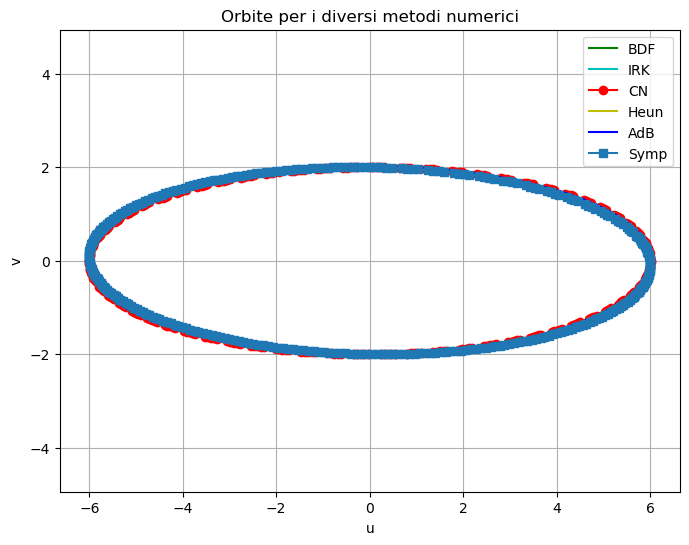

In [17]:
plt.figure(figsize=(8, 6))

plt.plot(y_BDF[0, :], y_BDF[1, :], 'g', label='BDF')
plt.plot(y_IRK[0, :], y_IRK[1, :], 'c', label='IRK')
plt.plot(y_ERK2[0, :], y_ERK2[1, :], 'o-r', label='CN')    
plt.plot(y_ERK3[0, :], y_ERK3[1, :], 'y', label='Heun')
plt.plot(y_AB3[0, :], y_AB3[1, :], 'b', label='AdB')
plt.plot(y_SYMP[0, :], y_SYMP[1, :], '-s', label='Symp')   

plt.title("Orbite per i diversi metodi numerici")
plt.xlabel("u")
plt.ylabel("v")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

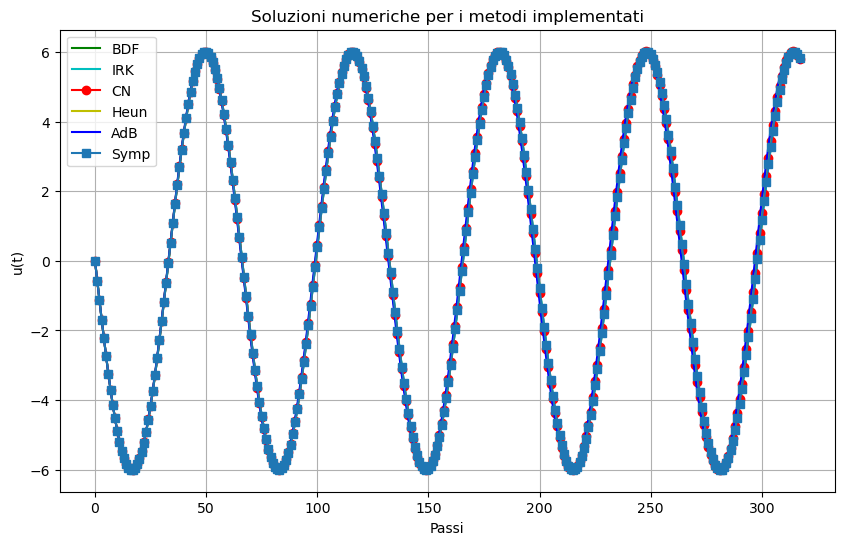

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(y_BDF[0, :], 'g', label='BDF')
plt.plot(y_IRK[0, :], 'c', label='IRK')
plt.plot(y_ERK2[0, :], 'o-r', label='CN')     
plt.plot(y_ERK3[0, :], 'y', label='Heun')
plt.plot(y_AB3[0, :], 'b', label='AdB')
plt.plot(y_SYMP[0, :], 's-', label='Symp')    

plt.xlabel("Passi")
plt.ylabel("u(t)")
plt.title("Soluzioni numeriche per i metodi implementati")
plt.legend()
plt.grid(True)
plt.show()

Mostriamo ora come e in che misura è conservata l'energia totale $E(t) = u(t)^2 + \omega^2 \cdot v(t)^2$ nel tempo, per vari metodi. Notiamo che il metodo simplettico in media conserva l'energia totale.


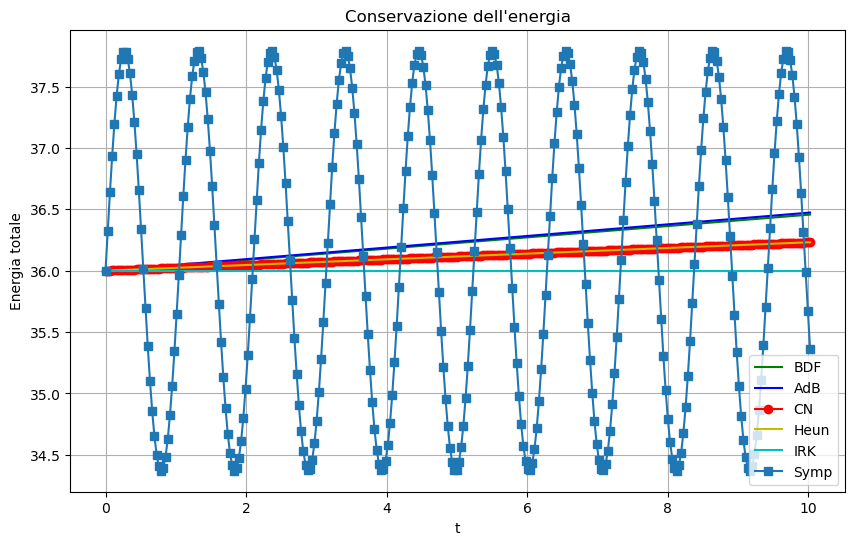

In [20]:
def energia_armonica(y, omega):
    u = y[0, :]
    v = y[1, :]
    return u**2 + (omega**2) * v**2

E_BDF = energia_armonica(y_BDF, w)
E_IRK = energia_armonica(y_IRK, w)
E_ERK2 = energia_armonica(y_ERK2, w)
E_ERK3 = energia_armonica(y_ERK3, w)
E_AB3 = energia_armonica(y_AB3, w)
E_SYMP = energia_armonica(y_SYMP, w)

plt.figure(figsize=(10, 6))

plt.plot(Ti, E_BDF, 'g', label='BDF')
plt.plot(Ti, E_AB3, 'b', label='AdB')
plt.plot(Ti, E_ERK2, 'o-r', label='CN')  
plt.plot(Ti, E_ERK3, 'y', label='Heun')
plt.plot(Ti, E_IRK, 'c', label='IRK')
plt.plot(Ti, E_SYMP, 's-', label='Symp') 

plt.xlabel("t")
plt.ylabel("Energia totale")
plt.title("Conservazione dell'energia")
plt.legend()
plt.grid(True)
plt.show()

Qui stampiamo il costo computazionale dei vari metodi. Notiamo che i metodi espliciti richiedono meno valutazioni del campo.


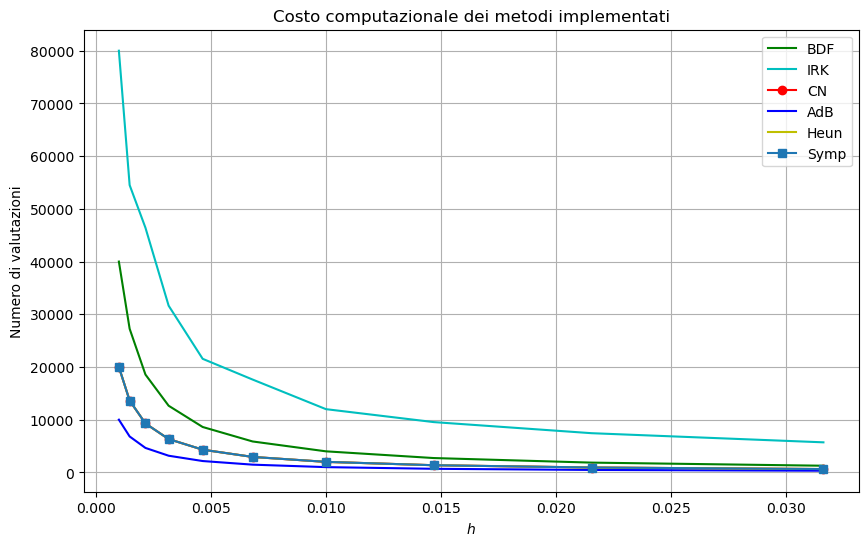

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(h_test, num_eval[0, :], 'g', label='BDF')
plt.plot(h_test, num_eval[1, :], 'c', label='IRK')
plt.plot(h_test, num_eval[2, :], 'o-r', label='CN')   
plt.plot(h_test, num_eval[3, :], 'b', label='AdB')    
plt.plot(h_test, num_eval[4, :], 'y', label='Heun')
plt.plot(h_test, num_eval[5, :], '-s', label='Symp')  

plt.xlabel(r"$h$")
plt.ylabel("Numero di valutazioni")
plt.title("Costo computazionale dei metodi implementati")
plt.legend()
plt.grid(True)
plt.show()